### Importing required libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the dataset

In [5]:
df= pd.read_csv('Downloads/CreditCardFraudDataset/fraudTrain.csv')

In [47]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

### Dropping the columns which are not necessary

In [7]:
df = df.drop(columns=['trans_date_trans_time', 'first', 'last', 'dob'])

In [8]:
df= df.drop(['Unnamed: 0'], axis=1)

In [9]:
df= df.drop(['street'],axis=1)

### Seperating the amount and unixtime features

In [10]:
amt= df.amt
time= df.unix_time
print(amt)
print(time)

0            4.97
1          107.23
2          220.11
3           45.00
4           41.96
            ...  
1296670     15.56
1296671     51.70
1296672    105.93
1296673     74.90
1296674      4.30
Name: amt, Length: 1296675, dtype: float64
0          1325376018
1          1325376044
2          1325376051
3          1325376076
4          1325376186
              ...    
1296670    1371816728
1296671    1371816739
1296672    1371816752
1296673    1371816816
1296674    1371816817
Name: unix_time, Length: 1296675, dtype: int64


In [11]:
df = df.drop(['amt','unix_time'],axis= 1)

### Generalising locations in a few clusters using the latitude and longitude

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters= 10, n_init=10, random_state=0)
df['location_cluster'] = kmeans.fit_predict(df[['lat', 'long']])

In [13]:
df['merch_cluster'] = kmeans.fit_predict(df[['merch_lat', 'merch_long']])

In [14]:
df= df.drop(['lat','long','merch_lat','merch_long','zip'],axis=1)

### Converting the categorical data into numerical values using one hot encoding and scaling the numerical values

In [15]:
numerical_features = ['cc_num', 'location_cluster', 'city_pop', 'merch_cluster']
categorical_features = ['merchant', 'category', 'gender', 'city', 'state', 'job']

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_features)
    ]
)

### Using TruncatedSVD to reduce the dimensionality of the data

In [17]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components=10))
])

In [18]:
df.columns

Index(['cc_num', 'merchant', 'category', 'gender', 'city', 'state', 'city_pop',
       'job', 'trans_num', 'is_fraud', 'location_cluster', 'merch_cluster'],
      dtype='object')

In [19]:
X = df.drop(columns=['is_fraud'])
y= df.is_fraud
y

0          0
1          0
2          0
3          0
4          0
          ..
1296670    0
1296671    0
1296672    0
1296673    0
1296674    0
Name: is_fraud, Length: 1296675, dtype: int64

In [20]:
X_transformed = pipeline.fit_transform(X)

In [21]:
X_df = pd.DataFrame(X_transformed, columns =['A', 'B', 'C','D','E','F','G','H','I','J']) 

In [22]:
X_df.head()

,A,B,C,D,E,F,G,H,I,J
0,-0.341352,0.066327,-0.377181,0.181117,0.938180,-0.426240,-0.041996,0.000146,0.024995,0.016138
1,0.167444,0.273538,-0.306785,2.183077,0.814753,-0.164137,-0.291387,0.734769,-0.470323,-0.132892
2,-0.179536,-0.252651,-0.524438,-1.710298,0.596478,0.723280,-0.045646,-0.006737,0.087411,0.054188
3,-0.182254,-0.271962,-0.529536,-1.724030,0.649395,0.733093,0.914755,0.021365,-0.138939,-0.078086
4,-0.429869,0.011488,-0.421105,-0.002056,0.466678,0.908959,-0.037459,-0.002347,0.060107,0.025042


### Concatenating the transformed data with the amount and time previously separated

In [23]:
X_df= pd.concat([X_df,amt,time],axis=1)

In [24]:
X_df= pd.concat([X_df,y], axis=1)
X_df.head()

,A,B,C,D,E,F,G,H,I,J,amt,unix_time,is_fraud
0,-0.341352,0.066327,-0.377181,0.181117,0.938180,-0.426240,-0.041996,0.000146,0.024995,0.016138,4.97,1325376018,0
1,0.167444,0.273538,-0.306785,2.183077,0.814753,-0.164137,-0.291387,0.734769,-0.470323,-0.132892,107.23,1325376044,0
2,-0.179536,-0.252651,-0.524438,-1.710298,0.596478,0.723280,-0.045646,-0.006737,0.087411,0.054188,220.11,1325376051,0
3,-0.182254,-0.271962,-0.529536,-1.724030,0.649395,0.733093,0.914755,0.021365,-0.138939,-0.078086,45.00,1325376076,0
4,-0.429869,0.011488,-0.421105,-0.002056,0.466678,0.908959,-0.037459,-0.002347,0.060107,0.025042,41.96,1325376186,0


### Seperating the legit and fraud transactions

In [25]:
legit= X_df[X_df.is_fraud==0]
fraud= X_df[X_df.is_fraud==1]

In [26]:
fraud.shape

(7506, 13)

In [27]:
legit

,A,B,C,D,E,F,G,H,I,J,amt,unix_time,is_fraud
0,-0.341352,0.066327,-0.377181,0.181117,0.938180,-0.426240,-0.041996,0.000146,0.024995,0.016138,4.97,1325376018,0
1,0.167444,0.273538,-0.306785,2.183077,0.814753,-0.164137,-0.291387,0.734769,-0.470323,-0.132892,107.23,1325376044,0
2,-0.179536,-0.252651,-0.524438,-1.710298,0.596478,0.723280,-0.045646,-0.006737,0.087411,0.054188,220.11,1325376051,0
3,-0.182254,-0.271962,-0.529536,-1.724030,0.649395,0.733093,0.914755,0.021365,-0.138939,-0.078086,45.00,1325376076,0
4,-0.429869,0.011488,-0.421105,-0.002056,0.466678,0.908959,-0.037459,-0.002347,0.060107,0.025042,41.96,1325376186,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,-0.179286,-0.266319,-0.531071,-1.735327,0.609826,0.721613,-0.041733,-0.006900,0.088294,0.052759,15.56,1371816728,0
1296671,-0.421786,0.006434,-0.418182,-0.004690,0.473957,0.909136,-0.041060,-0.011717,0.068797,0.073882,51.70,1371816739,0
1296672,-0.177181,-0.274495,-0.525370,-1.748647,0.617079,0.721693,-0.038169,-0.011573,0.072332,0.072232,105.93,1371816752,0
1296673,-0.179066,-0.262928,-0.532089,-1.721854,0.605016,0.720152,-0.043244,-0.012121,0.071517,0.073438,74.90,1371816816,0


### Resampling the data of legit transactions in order to prevent class imbalanace

In [28]:
legit_random_sample= legit.sample(7506)

In [29]:
legit_random_sample

,A,B,C,D,E,F,G,H,I,J,amt,unix_time,is_fraud
114310,1.897597,-0.408023,-0.601743,-0.798008,0.498138,0.928397,-0.025778,-0.004132,0.029958,0.024349,484.41,1330975828,0
1006710,-1.886908,0.219311,-0.324516,-0.327234,1.090620,-0.522286,-0.136183,-0.037015,0.616737,-0.613393,5.08,1361118812,0
1198722,0.165219,0.274588,-0.300392,2.175636,0.781601,-0.174715,-0.060004,-0.003250,0.073094,0.065862,4.64,1368703729,0
856011,-1.823505,0.516948,-0.056391,-0.381417,1.049501,-0.527206,-0.042637,-0.003314,0.055271,0.065353,71.82,1355662980,0
1232721,-0.940143,0.078978,-0.390719,0.007284,0.499656,0.880457,-0.047703,-0.006292,0.089877,0.056134,66.25,1369856930,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
434206,0.905385,-0.000352,-0.413278,0.932589,0.884999,-0.269953,-0.049409,-0.002099,0.061242,0.054816,3.58,1342194578,0
546361,-0.429463,0.166361,-0.324327,0.522437,0.458370,0.958772,-0.030112,-0.008162,0.031094,0.025697,58.39,1345606806,0
1198531,-0.492000,-1.989716,2.194289,0.317885,1.005433,-0.397223,0.919676,0.020349,-0.156644,-0.069042,52.54,1368692878,0
357492,-1.223961,-1.963762,2.433624,0.569624,0.930163,-0.418308,-0.035069,-0.002513,0.042965,0.030685,115.69,1339825240,0


In [30]:
train= pd.concat([legit_random_sample,fraud], axis=0)

In [31]:
train

,A,B,C,D,E,F,G,H,I,J,amt,unix_time,is_fraud
114310,1.897597,-0.408023,-0.601743,-0.798008,0.498138,0.928397,-0.025778,-0.004132,0.029958,0.024349,484.41,1330975828,0
1006710,-1.886908,0.219311,-0.324516,-0.327234,1.090620,-0.522286,-0.136183,-0.037015,0.616737,-0.613393,5.08,1361118812,0
1198722,0.165219,0.274588,-0.300392,2.175636,0.781601,-0.174715,-0.060004,-0.003250,0.073094,0.065862,4.64,1368703729,0
856011,-1.823505,0.516948,-0.056391,-0.381417,1.049501,-0.527206,-0.042637,-0.003314,0.055271,0.065353,71.82,1355662980,0
1232721,-0.940143,0.078978,-0.390719,0.007284,0.499656,0.880457,-0.047703,-0.006292,0.089877,0.056134,66.25,1369856930,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295399,0.723863,0.183152,-0.216259,0.123916,0.956093,-0.354019,-0.070748,-0.006266,0.081081,0.063069,977.01,1371776408,1
1295491,0.723902,0.183218,-0.216206,0.124011,0.957553,-0.353252,-0.071269,-0.006334,0.081883,0.063773,1210.91,1371779615,1
1295532,-0.895823,0.258472,-0.240540,-0.030228,0.527407,0.897772,0.908285,0.020231,-0.144101,-0.076612,10.24,1371781016,1
1295666,0.884994,-0.172011,-0.468212,-0.512683,1.109374,-0.398020,0.899745,0.017490,-0.156533,-0.064055,21.69,1371785180,1


### Seperating the target variable

In [32]:
Y= train.is_fraud
X_new= train.drop(['is_fraud'],axis=1)

### Scaling the time and amount features 

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_new[['unix_time', 'amt']] = scaler.fit_transform(X_new[['unix_time', 'amt']])

### Split the data into training and testing datasets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.2, random_state=2)

### Using Logistic Regression for fraud classification

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
model = LogisticRegression(random_state=42,  class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [37]:
y_pred = model.predict(X_test)

### Calculating all metrics

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
accuracy = accuracy_score(y_test, y_pred)

In [39]:
y_test.value_counts()

is_fraud
1    1504
0    1499
Name: count, dtype: int64

In [40]:
accuracy

0.8268398268398268

In [41]:
y_prob = model.predict_proba(X_test)[:, 1]

In [42]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

In [43]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

Accuracy: 0.83
Precision: 0.88
Recall: 0.75
F1 Score: 0.81
ROC AUC Score: 0.89


### Printing the confusion matrix

In [44]:
def conf(y_test,y_pred):
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
    cm_display.plot()
plt.show()

In [45]:
from sklearn import metrics

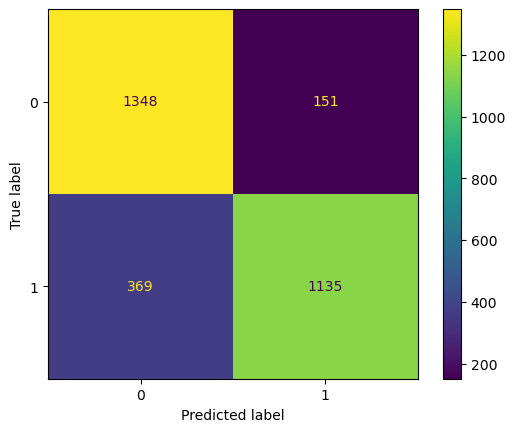

In [46]:
conf(y_test,y_pred)